In [31]:
import sys
import warnings
from config import *

DATASET = "PF00296"
sys.path.append(f"{ROOT}")
device = "cpu"

warnings.filterwarnings("ignore")

In [32]:
import numpy as np
import pandas as pd
import time
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ss_inference.data import SecondaryStructureRawDataset
from ss_inference.model import NetSurfP2
from ss_inference.utils import *

from config import DATA
from pgm.data import SequenceData
from pgm.layers import GaussianLayer, OneHotLayer
from pgm.edge import Edge
from pgm.model import MRF
from pgm.utils import *

from pattern_matching.loss import PatternMatchingLoss, QuickPatternMatchingLoss

torch.cuda.is_available()

True

## DCA Rejection Sampling

https://en.wikipedia.org/wiki/Rejection_sampling

### Independant model

Let's consider an independant model such that $E(x) = \sum_i g_i(x_i) = g(x)$. We want to extend it to include secondary structure QA. We consider $r$ a pattern a $R$ the set of secondary structure matching pattern $r$.
$$M(x) = \sum_{s \in R} \mathbb P(s|x)$$

Then $m(x) = - \log(M(x))$. We can then establish that $E(x) = g(x) + m(x)$. If we want to weight the two value we set $E$ to be $E(x) = g(x) + \frac{1}{T} m(x)$. We then have :

$$\mathbb{P}(x) = \frac{1}{Z} G(x)M(x)^{1/T}$$

How do we sample according to this probability ? Sampling with G(x) is easy but $M(x)$ is not invertible. We rely on rejection sampling.

To do this we sample following to the process :
- We sample $X$ according to $G(x)$ and $U$ according to a unifrom distrbituion in $[0,1]$
- if $M(X)^{1/T} < U$ we accept the sample, else we reject the sample and go back to step 1

We then have :
$$\mathbb{P}(X = x) \propto G(x)M(x)^{1/T}$$

## SS3 prediction

In [33]:
model_ss3 = NetSurfP2(50)
optimizer = optim.Adam(model_ss3.parameters(), lr=0.001)
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/lstm_50feats.h5"))
model_ss3.eval()
model_ss3 = model_ss3.to("cuda")

model_ss3

NetSurfP2(
  (conv1): ResBlock(
    (conv_1): ConvBlock(
      (conv): Conv1d(50, 32, kernel_size=(129,), stride=(1,), padding=(64,))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (normalization): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): ResBlock(
    (conv_1): ConvBlock(
      (conv): Conv1d(32, 32, kernel_size=(257,), stride=(1,), padding=(128,))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      (normalization): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (lstm1): LSTM(82, 1024, bidi

## Data

In [49]:
train_dataset = SequenceData(f"{DATA}/{DATASET}", dataset="train")
train_loader = DataLoader(train_dataset, batch_size = 30, 
                          shuffle = True, drop_last = True)

val_dataset = SequenceData(f"{DATA}/{DATASET}", dataset="val")
val_loader = DataLoader(val_dataset, batch_size = 30, drop_last = True)

N, qv = train_dataset.raw_sequences.shape[1], train_dataset.raw_sequences.shape[2]

In [35]:
independant = np.zeros((train_dataset.raw_sequences.shape[1], train_dataset.raw_sequences.shape[2]))
for w, v in zip(train_dataset.weights,train_dataset.raw_sequences):
    independant += w*v
independant /= np.sum(train_dataset.weights)
independant = torch.FloatTensor(independant).to(device)

In [36]:
from torch.distributions.one_hot_categorical import OneHotCategorical

independant_sampler = OneHotCategorical(independant)

In [37]:
pots = np.zeros((train_dataset.raw_sequences.shape[1], train_dataset.raw_sequences.shape[2]))
for w, v in zip(train_dataset.weights,train_dataset.raw_sequences):
    pots += w*v
pots /= np.sum(train_dataset.weights)
pots = pots.T
pots = torch.FloatTensor((pots.T-np.mean(pots, 1)).T).reshape(-1).to(device)

## RBM

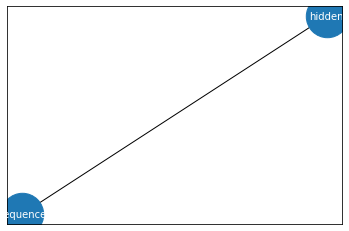

TypeError: ais() got an unexpected keyword argument 'n_iter'

In [38]:
visible_layers = ["sequence"]
hidden_layers = ["hidden"]

v = OneHotLayer(pots, N=N, q=qv, name="sequence")
h = GaussianLayer(N=1000, name="hidden")

E = [(v.name, h.name)]

model1 = MRF(layers={v.name: v,
                    h.name: h},
            edges=E)

for visible in visible_layers:
    edge = model1.get_edge(visible, "hidden")
    
model1.load(f"{DATA}/{DATASET}/weights/seq-reg-1000_150.h5")
model1.ais(n_inter = 20000, verbose = True)

In [39]:
model1.ais(n_inter = 20000, verbose = True)

Iteration 0 : -4.272460864740424e-05
Iteration 2000 : 119.15225828495113
Iteration 4000 : 508.3628956010589
Iteration 6000 : 1230.5273480048427
Iteration 8000 : 2345.0913991859206
Iteration 10000 : 3924.5064020087966
Iteration 12000 : 6041.8340753247985
Iteration 14000 : 8729.372380130553
Iteration 16000 : 11986.189762585425
Iteration 18000 : 15800.490837328696
Estimated Z : 17.440


17.440141677856445

## Rejection Sampling

In [40]:
seq_hmm = torch.tensor(train_dataset[0][3]).t()[20:]
seq_hmm.shape

torch.Size([30, 1464])

In [41]:
torch.save(seq_hmm, f"{DATA}/{DATASET}/hmm.pt")

In [42]:
seq_hmm = torch.tensor(train_dataset[0][3]).t()[20:]
_, size = seq_hmm.size()

In [51]:
from random import random

def rejection_sampling(model, matcher, n_samples, T, visible_layers = None, hidden_layers = None):
    samples = []
    while(True):
        for batch_idx, data in enumerate(train_loader):
            print(f"{len(samples)}/{n_samples} [{int(100*len(samples)/n_samples)}%]", end="\r")
            if model == "natural":
                x = data[0].permute(0,2,1)
            elif model == "independant":
                x = independant_sampler.sample_n(200).permute(0,2,1)
            else:
                d_0 = {k: v.float().permute(0, 2, 1).to(device) for k, v in zip(LAYERS_NAME, data[:1]) if k in visible_layers}
                batch_size, q, N = d_0["sequence"].size()
                _, d_f = model.gibbs_sampling(d_0, visible_layers, hidden_layers, k=30)
                x = d_f["sequence"]
            mx = matcher(x).detach()
            print(np.exp(mx))
            for x_, mx_ in zip(x, mx):
                if len(samples) >= n_samples:
                    return samples
                thr = np.exp(mx_/T)
                if random() < thr:
                    samples.append((x_, -mx_))

In [46]:
inf = float("Inf")
n_patterns, c_patterns, _ =  pickle.load(open(f"{DATA}/{DATASET}/patterns.pkl","rb"))
ss_hmm = torch.tensor(pickle.load(open(f"{DATA}/{DATASET}/ss_profile.pkl","rb")))
regexes = []
for x in n_patterns:
    if len(x):
        regexes.append([(i,None,None) for i in x])
# Q,_,_ = pickle.load(open(f"{DATA}/secondary_structure/statistics.pkl", "rb"))
Q = np.ones((4, size+1, size+1)) * (-np.inf)
e = 30
for i in range(size - e):
    Q[:3, i, i:i+e] = 0
    Q[3, i, i] = 0
Q = Q.reshape(1, *Q.shape)

matcher = PatternMatchingLoss(model_ss3, pattern = regexes[0], Q = Q, seq_hmm = seq_hmm, ss_hmm = ss_hmm, size = size)
# matcher = QuickPatternMatchingLoss(model_ss3, seq_hmm, ss_hmm, size=200)

In [52]:
all_samples_hist = []
all_samples = []
Ts = [0.05, 0.1, 0.5, 1, 10000][::-1]
for T in Ts:
    start = time.time()
    samples = rejection_sampling(model1, matcher, 2000, T, visible_layers, hidden_layers)
    all_samples_hist.append([x[1] for x in samples])
    all_samples.append([x[0] for x in samples])
    print(f"T = {T} || Samples/seconds : {int(2000/(time.time()-start))}")
    break

tensor([0.7354, 0.7718, 0.6820, 0.6671, 0.7183, 0.6941, 0.7014, 0.7169, 0.7812,
        0.7370, 0.7475, 0.6771, 0.7235, 0.6756, 0.7149, 0.6975, 0.7089, 0.6988,
        0.6930, 0.7297, 0.7222, 0.7059, 0.7098, 0.7069, 0.7146, 0.7847, 0.6974,
        0.6991, 0.7002, 0.7040])
tensor([0.7699, 0.7409, 0.6832, 0.6807, 0.7086, 0.6935, 0.7592, 0.6121, 0.6854,
        0.7837, 0.7203, 0.5688, 0.7937, 0.6737, 0.7879, 0.7209, 0.7049, 0.6896,
        0.7102, 0.7150, 0.7094, 0.7259, 0.7352, 0.7319, 0.7699, 0.6904, 0.7549,
        0.7279, 0.7598, 0.7264])
tensor([0.7205, 0.7658, 0.6820, 0.7312, 0.7649, 0.7033, 0.7256, 0.7251, 0.6905,
        0.7726, 0.7069, 0.7450, 0.7217, 0.7239, 0.7181, 0.7295, 0.7203, 0.7430,
        0.7196, 0.7044, 0.7012, 0.7030, 0.7198, 0.7076, 0.6707, 0.6984, 0.7071,
        0.4122, 0.7084, 0.6644])
tensor([0.7426, 0.6842, 0.7235, 0.7346, 0.7281, 0.6974, 0.7406, 0.5405, 0.6820,
        0.7594, 0.7042, 0.7132, 0.6883, 0.7029, 0.6784, 0.7295, 0.7326, 0.7656,
        0.7213, 0.729

In [29]:
all_samples = [torch.cat([s_.view(1, *s_.size()) for s_ in s],0) for s in all_samples]

In [30]:
for T, s in zip(Ts, all_samples):
    torch.save(s, f"{DATA}/{DATASET}/gen_data/rbm_rejection_sampling_T_{T}.pt")
#     torch.save(s, f"{DATA}/{DATASET}/gen_data/ind_rejection_sampling_T_{T}.pt")
#     torch.save(s, f"{DATA}/{DATASET}/gen_data/natural.pt")

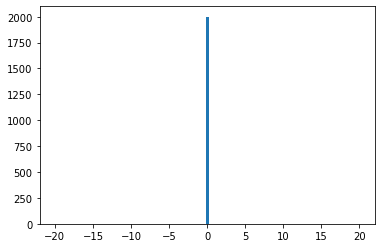

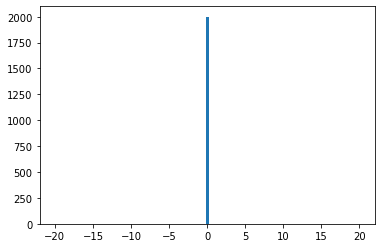

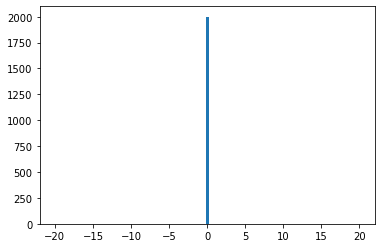

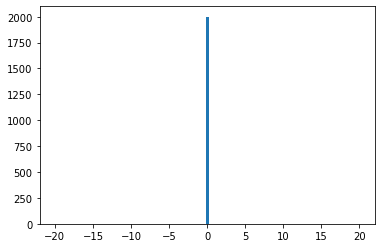

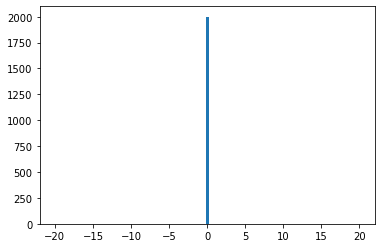

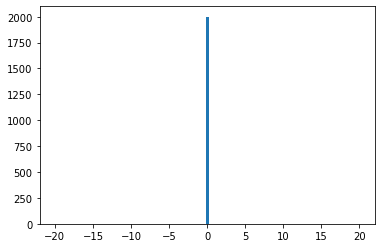

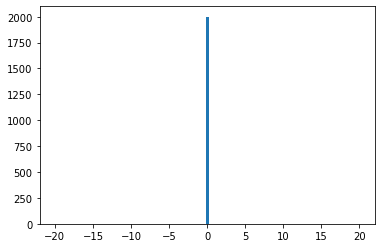

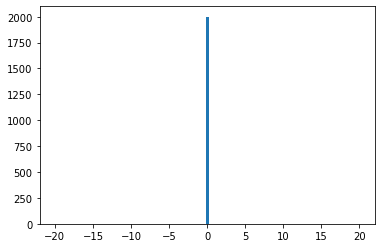

In [21]:
pdfs = []
x = np.linspace(-20, 20, 100)

for T,y in zip(Ts,all_samples_hist):
    mu, std = np.log(np.array(y)).mean(0), np.log(np.array(y)).std(0)
#     a,b = torch.tensor((mu-mini)**2 / std), torch.tensor(mu/std)
    pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * std**2)) / (x * std * np.sqrt(2 * np.pi)))
    pdfs.append(pdf)
    plt.hist(y, bins = x)
#     plt.plot(x, pdf)
#     plt.xticks(np.linspace(-20, 0, 8), np.round(np.exp(np.linspace(-20, 0, 8)/T),3), rotation = 45)
    plt.show()

In [19]:
for pdf in pdfs:
    plt.plot(x, pdf)
plt.legend(Ts)
plt.show()

NameError: name 'pdfs' is not defined